In [47]:
from torch.utils.data import Dataset, DataLoader
import numpy as np


class TimeSeriesSlidingWindowDataset(Dataset):
    def __init__(self, X, y, window_size, prediction_horizon=1):
        self.X = X
        self.y = y
        self.window_size = window_size
        self.prediction_horizon = prediction_horizon - 1
        self.shape = self.__getshape__()

    def __len__(self):
        return len(self.y) - self.window_size

    def __getitem__(self, index):
        return (self.X[:, index:index+self.window_size], self.y[np.newaxis, index+self.window_size+self.prediction_horizon, np.newaxis])

    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)


class TimeSeriesSlidingWindowDataset(Dataset):
    def __init__(self, X, y, window_size, prediction_horizon=1):
        self.X = X
        self.y = y
        self.window_size = window_size
        self.prediction_horizon = prediction_horizon - 1
        self.shape = self.__getshape__()

    def __len__(self):
        return len(self.y) - self.window_size

    def __getitem__(self, index):
        return (self.X[:, index:index+self.window_size], self.y[np.newaxis, index+self.window_size+self.prediction_horizon, np.newaxis])

    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)


def build_dataset_simple(prediction_horizon, data_path):
    data = pd.read_csv(data_path, index_col=0).iloc[::-1].reset_index(drop=True)
    # X = torch.tensor(data.values.astype(np.float32)).reshape(data.shape[1], data.shape[0])
    y = torch.tensor(data['close'].values.astype(np.float32))
    X = torch.tensor(data['close'].values.astype(np.float32))
    X = np.log(X)

    y = y[prediction_horizon:]
    y = y[np.newaxis, :, np.newaxis]
    X = X[:-prediction_horizon]
    X = X[np.newaxis, :, np.newaxis]
    
    X = (X - X.mean()) / X.std()
    y = (y - y.mean()) / y.std()

    return torch.tensor(X), torch.tensor(y)
    

In [46]:
import torch
from torch.utils.data.dataset import Dataset

# 10th order NARMA task
class MyDataset(Dataset):
    # Constructor
    def __init__(self, X, y, window_size, prediction_horizon, data_path='../input/input_data.csv'):

        self.inputs, self.outputs = X, y
        self.n_samples = X.shape[0]

    # Length
    def __len__(self):
        """
        Length
        :return:
        """
        return self.n_samples
    # end __len__

    # Get item
    def __getitem__(self, idx):
        """
        Get item
        :param idx:
        :return:
        """
        return self.inputs[idx], self.outputs[idx]

In [227]:
inputs.shape

torch.Size([1, 7366, 1])

Train MSE: 0.00785790104418993
Test NRMSE: 0.09170596206619577

Test MSE: 0.01822308450937271
Test NRMSE: 0.21737415334175805



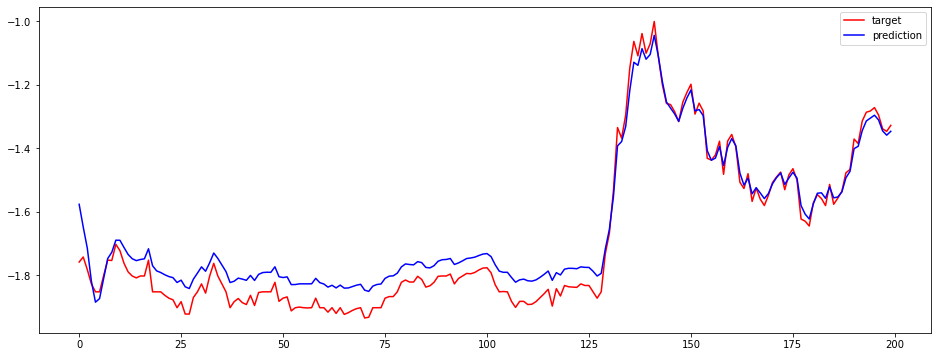

In [52]:
import torch
from echotorch.datasets.NARMADataset import NARMADataset
import echotorch.nn.reservoir as etrs
import echotorch.utils
import echotorch.utils.matrix_generation as mg
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Reservoir hyper-parameters
spectral_radius = 1.1
leaky_rate = 0.9261
input_dim = 1
reservoir_size = 400
connectivity = 0.2
ridge_param = 0.00000409
input_scaling = 0.9252
bias_scaling = 0.079079

params = {'spectral_radius': 0.0, 'leaky_rate': 0.7000000000000001, 'reservoir_size': 50, 'connectivity': 0.2, 'ridge_param': 2.1544346900318823e-05, 'input_scaling': 0.5, 'bias_scaling': 0.6000000000000001}
spectral_radius = params['spectral_radius']
leaky_rate = params['leaky_rate']
input_dim = 1
reservoir_size = params['reservoir_size']
connectivity = params['connectivity']
ridge_param = params['ridge_param']
input_scaling = params['input_scaling']
bias_scaling = params['bias_scaling']

batch_size = 1 

# Internal matrix
w_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    spetral_radius=spectral_radius
)

# Input weights
win_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    scale=input_scaling,
    apply_spectral_radius=False
)

# Bias vector
wbias_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    scale=bias_scaling,
    apply_spectral_radius=False
)

esn = etrs.LiESN(
    input_dim=input_dim,
    hidden_dim=reservoir_size,
    output_dim=1,
    leaky_rate=leaky_rate,
    learning_algo='inv',
    w_generator=w_generator,
    win_generator=win_generator,
    wbias_generator=wbias_generator,
    ridge_param=ridge_param,
    washout=0
)
# data parameters
window_size = 1
prediction_horizon = 

X, y = build_dataset_simple(window_size, prediction_horizon, data_path='../data/input_data.csv')

train_len = int(X.shape[1] * 0.8)
X_train = X[:, :train_len, :]
X_test = X[:, train_len:, :]
y_train = y[:, :train_len, :]
y_test = y[:, train_len:, :]

# X_train = X[:train_len]
# X_test = X[train_len:]
# y_train = y[:train_len]
# y_test = y[train_len:]

dataset_train = MyDataset(X_train, y_train, window_size, prediction_horizon, data_path='../data/input_data.csv')
dataset_test = MyDataset(X_test, y_test, window_size, prediction_horizon, data_path='../data/input_data.csv')

trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

for data in trainloader:
    # Inputs and outputs
    inputs, targets = data

    # Transform data to Variables
    inputs, targets = Variable(inputs), Variable(targets)

    # ESN need inputs and targets
    esn(inputs, targets)
# Now we finalize the training by

# computing the output matrix Wout.
esn.finalize()

# Train MSE
dataiter = iter(trainloader)
train_u, train_y = dataiter.next()
train_u, train_y = Variable(train_u), Variable(train_y)
y_predicted = esn(train_u)
print(u"Train RMSE: {}".format(echotorch.utils.rmse(y_predicted.data, train_y.data)))
print(u"")

# Test MSE
dataiter = iter(testloader)
test_u, test_y = dataiter.next()
test_u, test_y = Variable(test_u), Variable(test_y)
y_predicted = esn(test_u)
print(u"Test RMSE: {}".format(echotorch.utils.rmse(y_predicted.data, test_y.data)))
print(u"")

# Show target and predicted
plt.figure(figsize=(16, 6))
plot_length = 200
plt.plot(test_u[0, :plot_length, 0].data, 'r')
plt.plot(y_predicted[0, :plot_length, 0].data, 'b')
plt.legend(['target', 'prediction'])
plt.show()


In [45]:
targets.shape

torch.Size([1])

In [49]:
import echotorch.utils.optimization as optim
import numpy as np

from narma_evaluation import evaluation_function


# Manual seed initialisation
np.random.seed(1)
torch.manual_seed(1)

# Get a random optimizer
random_optimizer = optim.optimizer_factory.get_optimizer('random', R=50)

# Parameters ranges
param_ranges = dict()
param_ranges['spectral_radius'] = np.arange(0, 1.1, 0.1)
param_ranges['leaky_rate'] = np.arange(0.1, 1.1, 0.1)
param_ranges['reservoir_size'] = np.arange(50, 500, 50)
param_ranges['connectivity'] = np.arange(0.1, 1.0, 0.1)
param_ranges['ridge_param'] = np.logspace(-10, 2, base=10, num=10)
param_ranges['input_scaling'] = np.arange(0.1, 1.1, 0.1)
param_ranges['bias_scaling'] = np.arange(0.0, 1.1, 0.1)


# data parameters
window_size = 1
prediction_horizon = 5

X, y = build_dataset_simple(window_size, prediction_horizon, data_path='../data/input_data.csv')

train_len = int(X.shape[1] * 0.8)
X_train = X[:, :train_len, :]
X_test = X[:, train_len:, :]
y_train = y[:, :train_len, :]
y_test = y[:, train_len:, :]

dataset_train = MyDataset(X_train, y_train, window_size, prediction_horizon, data_path='../data/input_data.csv')
dataset_test = MyDataset(X_test, y_test, window_size, prediction_horizon, data_path='../data/input_data.csv')

# Launch the optimization of hyper-parameters
_, best_param, best_NRMSE = random_optimizer.optimize(
    evaluation_function,
    param_ranges,
    (dataset_train, dataset_test),
    n_samples=5
)

# Show the result
print("Best hyper-parameters found : {}".format(best_param))
print("Best NRMSE : {}".format(best_NRMSE))

Best hyper-parameters found : {'spectral_radius': 0.0, 'leaky_rate': 0.7000000000000001, 'reservoir_size': 50, 'connectivity': 0.2, 'ridge_param': 2.1544346900318823e-05, 'input_scaling': 0.5, 'bias_scaling': 0.6000000000000001}
Best NRMSE : 0.21635329928993427


In [3]:

def evaluation_function(parameters, datasets, n_samples=5):
    """
    Test the ESN with specific parameters on NARMA-10
    :param parameters: Dictionary with parameters values
    :param datasets: The dataset for the evaluation
    :param n_samples: How many samples to test the model ?
    :return: A tuple (model, fitness value)
    """
    # Batch size (how many sample processed at the same time?)
    batch_size = 1

    # Predicted/target plot length
    plot_length = 200

    # Use CUDA?
    use_cuda = False
    use_cuda = torch.cuda.is_available() if use_cuda else False

    # Reservoir hyper-parameters
    spectral_radius = parameters['spectral_radius']
    leaky_rate = parameters['leaky_rate']
    input_dim = 1
    reservoir_size = parameters['reservoir_size']
    connectivity = parameters['connectivity']
    ridge_param = parameters['ridge_param']
    input_scaling = parameters['input_scaling']
    bias_scaling = parameters['bias_scaling']

    # Data loader
    trainloader = DataLoader(datasets[0], batch_size=batch_size, shuffle=False)
    testloader = DataLoader(datasets[1], batch_size=batch_size, shuffle=False)

    # Average NRMSE
    NRMSE_average = 0.0

    # For each samples
    for n in range(n_samples):
        # Internal matrix
        w_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
            connectivity=connectivity,
            spetral_radius=spectral_radius
        )

        # Input weights
        win_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
            connectivity=connectivity,
            scale=input_scaling,
            apply_spectral_radius=False
        )

        # Bias vector
        wbias_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
            connectivity=connectivity,
            scale=bias_scaling,
            apply_spectral_radius=False
        )

        # Create a Leaky-integrated ESN,
        # with least-square training algo.
        # esn = etrs.ESN(
        esn = etrs.LiESN(
            input_dim=input_dim,
            hidden_dim=reservoir_size,
            output_dim=1,
            leaky_rate=leaky_rate,
            learning_algo='inv',
            w_generator=w_generator,
            win_generator=win_generator,
            wbias_generator=wbias_generator,
            ridge_param=ridge_param
        )

        # Transfer in the GPU if possible
        if use_cuda:
            esn.cuda()
        # end if

        # For each batch
        for data in trainloader:
            # Inputs and outputs
            inputs, targets = data

            # Transform data to Variables
            inputs, targets = Variable(inputs), Variable(targets)
            if use_cuda: inputs, targets = inputs.cuda(), targets.cuda()

            # ESN need inputs and targets
            esn(inputs, targets)
        # end for

        # Now we finalize the training by
        # computing the output matrix Wout.
        esn.finalize()

        # Get the first sample in test set,
        # and transform it to Variable.
        dataiter = iter(testloader)
        test_u, test_y = dataiter.next()
        test_u, test_y = Variable(test_u), Variable(test_y)
        if use_cuda: test_u, test_y = test_u.cuda(), test_y.cuda()

        # Make a prediction with our trained ESN
        y_predicted = esn(test_u)

        # Add to sum of NRMSE
        NRMSE_average += echotorch.utils.nrmse(y_predicted.data, test_y.data)
    # end for

    # Print test MSE and NRMSE
    return esn, NRMSE_average / n_samples
# end evaluation_function


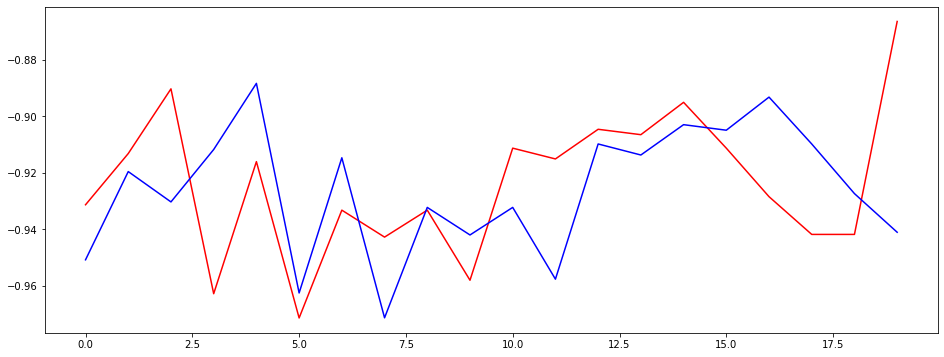

In [186]:
# data parameters
window_size = 1
prediction_horizon = 2

X, y = build_dataset_simple(window_size, prediction_horizon, data_path='../data/input_data.csv')

train_len = int(X.shape[1] * 0.9)
X_train = X[:, :train_len, :]
X_test = X[:, train_len:, :]
y_train = y[:, :train_len, :]
y_test = y[:, train_len:, :]


# Transform data to Variables
inputs, targets = Variable(X_train), Variable(y_train)

# inputs, targets = Variable(X_test), Variable(y_test)
plt.figure(figsize=(16, 6))
plot_length = 20
plt.plot(targets[0, :plot_length, 0].data, 'r')
plt.plot(inputs[0, :plot_length, 0].data, 'b')
plt.show()

In [14]:
import torch
from echotorch.datasets.NARMADataset import NARMADataset
import echotorch.nn.reservoir as etrs
import echotorch.utils
import echotorch.utils.matrix_generation as mg
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Length of training samples
train_sample_length = 5000

# Length of test samples
test_sample_length = 1000

# How many training/test samples
n_train_samples = 1
n_test_samples = 1

# Batch size (how many sample processed at the same time?)
batch_size = 1

# Reservoir hyper-parameters
spectral_radius = 1.07
leaky_rate = 0.9261
input_dim = 1
reservoir_size = 410
connectivity = 0.1954
ridge_param = 0.00000409
input_scaling = 0.9252
bias_scaling = 0.079079

# Predicted/target plot length
plot_length = 200

# Use CUDA?
use_cuda = False
use_cuda = torch.cuda.is_available() if use_cuda else False

# Manual seed initialisation
np.random.seed(1)
torch.manual_seed(1)

# NARMA30 dataset
narma10_train_dataset = NARMADataset(train_sample_length, n_train_samples, system_order=10)
narma10_test_dataset = NARMADataset(test_sample_length, n_test_samples, system_order=10)

In [195]:
narma10_train_dataset

In [40]:
import torch
from echotorch.datasets.NARMADataset import NARMADataset
import echotorch.nn.reservoir as etrs
import echotorch.utils
import echotorch.utils.matrix_generation as mg
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Length of training samples
train_sample_length = 5000

# Length of test samples
test_sample_length = 1000

# How many training/test samples
n_train_samples = 1
n_test_samples = 1

# Batch size (how many sample processed at the same time?)
batch_size = 1

# Reservoir hyper-parameters
spectral_radius = 1.07
leaky_rate = 0.9261
input_dim = 1
reservoir_size = 410
connectivity = 0.1954
ridge_param = 0.00000409
input_scaling = 0.9252
bias_scaling = 0.079079

# Predicted/target plot length
plot_length = 200

# Use CUDA?
use_cuda = False
use_cuda = torch.cuda.is_available() if use_cuda else False

# Manual seed initialisation
np.random.seed(1)
torch.manual_seed(1)

# NARMA30 dataset
narma10_train_dataset = NARMADataset(train_sample_length, n_train_samples, system_order=10)
narma10_test_dataset = NARMADataset(test_sample_length, n_test_samples, system_order=10)

# Data loader
dataset = build_dataset(2, 1, '../data/input_data.csv')
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
# trainloader = DataLoader(narma10_train_dataset, batch_size=batch_size, shuffle=False)
# testloader = DataLoader(narma10_test_dataset, batch_size=batch_size, shuffle=False)

# Internal matrix
w_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    spetral_radius=spectral_radius
)

# Input weights
win_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    scale=input_scaling,
    apply_spectral_radius=False
)

# Bias vector
wbias_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    scale=bias_scaling,
    apply_spectral_radius=False
)

# Create a Leaky-integrated ESN,
# with least-square training algo.
# esn = etrs.ESN(
esn = etrs.ESN(
    input_dim=input_dim,
    hidden_dim=reservoir_size,
    output_dim=1,
    learning_algo='inv',
    w_generator=w_generator,
    win_generator=win_generator,
    wbias_generator=wbias_generator,
    ridge_param=ridge_param
)

# Transfer in the GPU if possible
if use_cuda:
    esn.cuda()
# end if

# For each batch
for data in trainloader:
    # Inputs and outputs
    inputs, targets = data

    # Transform data to Variables
    inputs, targets = Variable(inputs), Variable(targets)
    if use_cuda: inputs, targets = inputs.cuda(), targets.cuda()

    # ESN need inputs and targets
    esn(inputs, targets)
# end for

# Now we finalize the training by
# computing the output matrix Wout.
esn.finalize()

# Get the first sample in training set,
# and transform it to Variable.
dataiter = iter(trainloader)
train_u, train_y = dataiter.next()
train_u, train_y = Variable(train_u), Variable(train_y)
if use_cuda: train_u, train_y = train_u.cuda(), train_y.cuda()

# Make a prediction with our trained ESN
y_predicted = esn(train_u)

# Print training MSE and NRMSE
print(u"Train MSE: {}".format(echotorch.utils.mse(y_predicted.data, train_y.data)))
print(u"Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, train_y.data)))
print(u"")

# Get the first sample in test set,
# and transform it to Variable.
dataiter = iter(testloader)
test_u, test_y = dataiter.next()
test_u, test_y = Variable(test_u), Variable(test_y)
if use_cuda: test_u, test_y = test_u.cuda(), test_y.cuda()

# Make a prediction with our trained ESN
y_predicted = esn(test_u)

# Print test MSE and NRMSE
print(u"Test MSE: {}".format(echotorch.utils.mse(y_predicted.data, test_y.data)))
print(u"Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, test_y.data)))
print(u"")

# Show target and predicted
plt.plot(test_y[0, :plot_length, 0].data, 'r')
plt.plot(y_predicted[0, :plot_length, 0].data, 'b')
plt.show()

IndexError: too many indices for tensor of dimension 1

In [32]:
esn = etrs.ESN(
    input_dim=input_dim,
    hidden_dim=reservoir_size,
    output_dim=1,
    learning_algo='inv',
    w_generator=w_generator,
    win_generator=win_generator,
    wbias_generator=wbias_generator,
    ridge_param=ridge_param
)

esn([10], [2]).__str__()

AttributeError: 'list' object has no attribute 'size'

torch.Size([1, 5000, 1])
torch.Size([1, 5000, 1])


In [36]:

for data in trainloader:
    # Inputs and outputs
    inputs, targets = data
    print(inputs.shape)
    print(targets.shape)
    break

torch.Size([1, 5, 2])
torch.Size([1, 1, 1])


In [42]:
import echotorch.datasets as etds
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt


# A dataset of sine patterns
sine_dataset = etds.SinusoidalTimeseries(sample_len=1000, n_samples=1, period=9.3547)

# Timeseries batch sequence dataset
sine_sequence_dataset = etds.TimeseriesBatchSequencesDataset(
    root_dataset=sine_dataset,
    window_size=100,
    stride=100,
    data_indices=None,
    dataset_in_memory=True
)

# Data loader
sine_dataset_loader = DataLoader(sine_dataset, batch_size=1, shuffle=False)
sine_sequence_loader = DataLoader(sine_sequence_dataset, batch_size=1, shuffle=False)

# For each sample
for data in sine_sequence_loader:
    # Plot
    print(data.shape)
# end for

torch.Size([1, 100, 1])
torch.Size([1, 100, 1])
torch.Size([1, 100, 1])
torch.Size([1, 100, 1])
torch.Size([1, 100, 1])
torch.Size([1, 100, 1])
torch.Size([1, 100, 1])
torch.Size([1, 100, 1])
torch.Size([1, 100, 1])
torch.Size([1, 100, 1])


1